# Tensorflow 2.1.0, distilBERT ve ktrain ile text classification

summarify.io case study tarafından temin edilen veri setini kullanacağız

# `DistilBERT` nedir?

DistilBert Bert base modelini "damıtarak" oluşturulmuş, daha küçük, daha hızlı, daha ucuz bir Transformer modelidir. Bert base modeline kıyasla %40 daha az parametreye sahip ve %60 daha hızlı çalışırken, Glue language understanding benchmark'larında yapılan ölçümlere göre Bert'in state-of-the-art performansının %97'ini korumaktadır.

![alt text](https://miro.medium.com/max/2000/1*IFVX74cEe8U5D1GveL1uZA.png)

## Neden `DistilBERT`



*   BERT Modeli ile %97 oranında aynı performansı sergiliyor
*   %60 daha hızlı 
*   %40 daha az parametre barındırıyor
*   CPU üzerinde çalışma kabiliyetine sahip

DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter

https://arxiv.org/abs/1910.01108

# `ktrain` nedir?

ktrain, Keras, TensorFlow ve transformers kütüphaneleri için bir wrapper'dır.

ktrain tek başına Keras yerine tf.keras kullanmaktadır. fastai kütüphanesinden esinlenerek üretilen k train sayesinde birkaç satır kod ile kolayca şunlar yapılabiliyor:


*   lr_find() fonksiyonu ile kendi datanız üzerinde optimal learning rate bulmak için simülasyonu üretmek
*   Modeli daha efektif eğitebilmek için SGDR, 1cycle policy, triangular learning rate policy gibi learning schedule'larını kullanmak
*   Hem text classification (örn., NBSVM, fastText, GRU with pretrained word embeddings) hem de image classification (örn., ResNet, Wide Residual Networks, Inception) için hızlı ve kullanması kolay pre-canned modelleri kullanmak 
*   Bir çok farklı formattaki text ve resim verilerini yüklemek ve ön işlem yapmak
*   Modeli geliştirmek için yanlış sınıflandırılmış verileri incelemek
*   Yeni ham veriler üzerinde tahminler yapmak için hem modelleri hem de veri ön işleme adımlarını kaydetmek ve dağıtmak için basit bir tahmin API'sinden yararlanmak

ktrain GitHub: https://github.com/amaiya/ktrain

ktrain notebook örneği: https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb

# Bu notebook için Google Colab'ı kullanacağım. Colab'ın ücretsiz erişimi dahilinde 4 farklı GPU temin verilebiliyor. Bunlardan en yüksek performans sergileyeni Tesla P100.

In [1]:
!nvidia-smi

Mon Oct 19 10:38:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Gerekli paketler

In [ ]:
!pip3 install ktrain

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from wordcloud import WordCloud

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls /content/drive/My\ Drive/*.py

'/content/drive/My Drive/helper.py'


In [ ]:
!cat '/content/drive/My Drive/helper.py'

In [8]:
import sys
sys.path.append('/content/drive/My Drive')

In [9]:
import helper

In [10]:
data = pd.read_csv("/content/drive/My Drive/sample_complaint_data_90k.csv")

# EDA: Keşifsel Veri Analizi

Keşifsel Veri Analizini psikoterapinin ilk süreçlerine benzetiyorum. Bir problemin ne olduğunu anlamak için, neden kaynaklandığını anlamak fayda sağlayacaktır. Özellikle bir deep learning modeli oluşturduğumuzda, bu modelin nasıl tahmin yürüttüğüne dair içgörü kazanmak için EDA çok faydalı oluyor.

### Hedef değişkenin dağılımna baktığımızda veri setinin tamamen dengeli bir şekilde oluşturulmuş olduğunu görüyoruz. Veri setinin dengeli olması, ön işleme sürecini oldukça kısaltıyor.

Text(0.5, 1.0, 'Şikayet Kategorisi')

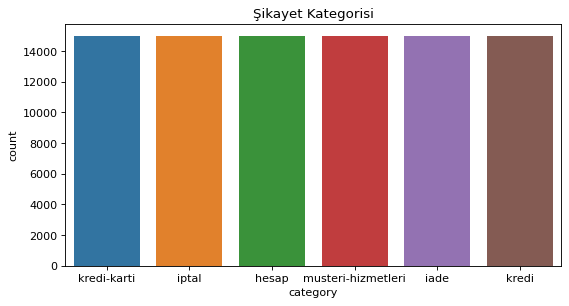

In [11]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80
sns.countplot('category', data=data)
plt.title('Şikayet Kategorisi')

In [12]:
# Her sınıf için 15000 örnek var

data["category"].value_counts()

iptal                 15000
hesap                 15000
kredi-karti           15000
iade                  15000
kredi                 15000
musteri-hizmetleri    15000
Name: category, dtype: int64

### Oluşturduğum `helper` modülünü kullanarak, her satır için temel özellikleri üreten bir veri seti tanımlayalım

In [13]:
data_spec = helper.basic_features(data)

In [14]:
data_spec.head()

# char_counts ---> Harf miktarı
# word_counts ---> Sözcük miktarı
# avg_wordlength ---> Ortalama sözcük uzunluğu

,text,category,char_counts,word_counts,avg_wordlength
0,7 senedir müşterisi olduğum Yapı Kredi Bankası...,kredi-karti,605,95,6.368421
1,Öğrencilik hayatım boyunca kullandığım İş'te ü...,kredi-karti,274,41,6.682927
2,03/04/2015 tarihli kredi kart ekstremde 76 TL ...,kredi-karti,199,28,7.107143
3,Bu nasıl iş yapmak! 30 dk. müşteri temsilcisiy...,kredi-karti,285,39,7.307692
4,Ziraat Bankası'ndan yeni bir kredi kartı aldım...,kredi-karti,224,37,6.054054


### Her giriş için yazılan şikayet metinlerinin, harf miktarı olarak uzunluğuna bakıldığında çoğunluğun 0:1000 karakter aralığında olduğu görülüyor.

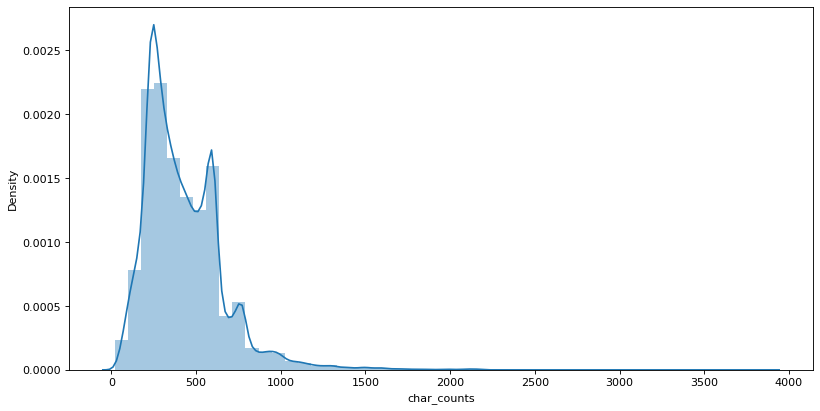

In [15]:
plt.rcParams['figure.figsize'] = [12,6]
sns.distplot(data_spec['char_counts'])

#### Bu karakter uzunluklarını sınıflara göre farklı dağılımlar olarak plot ettiğimizde "kredi" şikayetleri için metin uzunluğunun daha diğer şikayetlere göre daha kısa olduğu görülüyor.
#### "iptal" şikayetleri için ise yoğunluğun daha uzun metinlere kaydığı gözlemleniyor.

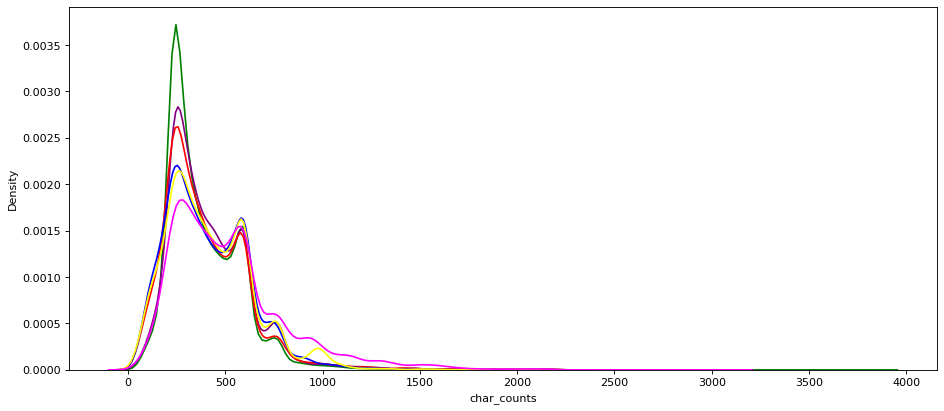

In [16]:
plt.rcParams['figure.figsize'] = [14,6]
sns.kdeplot(data_spec[data_spec['category']=="kredi"]['char_counts'], shade=False, color='green')
sns.kdeplot(data_spec[data_spec['category']=="musteri-hizmetleri"]['char_counts'], shade=False, color='purple')
sns.kdeplot(data_spec[data_spec['category']=="hesap"]['char_counts'], shade=False, color='red')
sns.kdeplot(data_spec[data_spec['category']=="iade"]['char_counts'], shade=False, color='blue')
sns.kdeplot(data_spec[data_spec['category']=="kredi-karti"]['char_counts'], shade=False, color='yellow')
sns.kdeplot(data_spec[data_spec['category']=="iptal"]['char_counts'], shade=False, color='magenta')

Şikayet sınıflarına göre karakter kullanımlarının ortalamalarına baktığımızda da bu durum görülüyor

In [17]:
means = data.groupby('category')['char_counts'].mean()

print("Şikayet uzunlukları için ortalama karakter uzunlukları")
print(means)

Şikayet uzunlukları için ortalama karakter uzunlukları
category
hesap                 402.512733
iade                  412.582667
iptal                 515.350933
kredi                 390.906733
kredi-karti           423.415600
musteri-hizmetleri    419.026600
Name: char_counts, dtype: float64


### Benzer şekilde kelime miktarlarına baktığımızda da yoğunluğun 0:200 arasında olduğu görülüyor. 

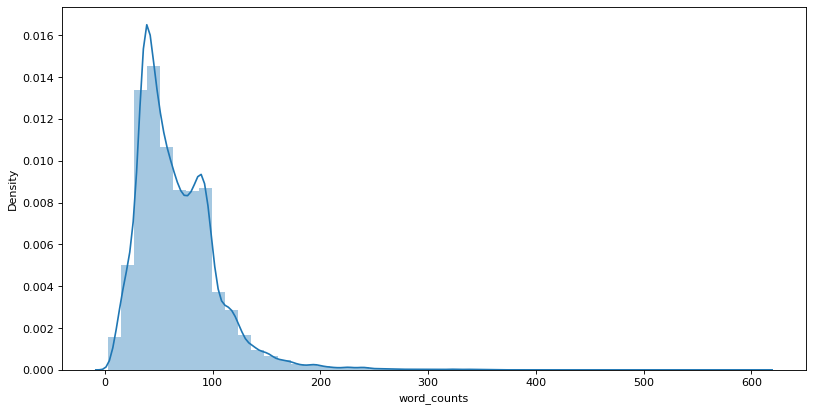

In [18]:
plt.rcParams['figure.figsize'] = [12,6]
sns.distplot(data_spec['word_counts'])

## Bert modelinde maksimum sequence length 512 olduğu için, girdilerdeki kelime sayılarını araştırmak faydalı olacaktır.

Her girdi için ortalama 66 kelime kullanılıyor ve ilk %75'lik dilim 87 kelime ve altından oluşuyor.
Bu değerlere bakıldığında, sequence length değerinin 150 seçilmesi yeterli olabilir gibi gözüküyor.
Aşağıda, model parametrelerini girerken bununla ilgili daha detaylı ve deneysel bilgi verdim.

In [19]:
print("Ortalama kelime miktarı", np.mean(data_spec['word_counts']))
print(" ")
print("Kelime miktarı özeti")
print(data_spec['word_counts'].describe())

Ortalama kelime miktarı 66.61671111111112
 
Kelime miktarı özeti
count    90000.000000
mean        66.616711
std         36.987844
min          3.000000
25%         40.000000
50%         59.000000
75%         87.000000
max        608.000000
Name: word_counts, dtype: float64


Sınıflara göre ortalama kelime uzunluğu. Yorum yapmaya değecek bir bilgi bulamadım.

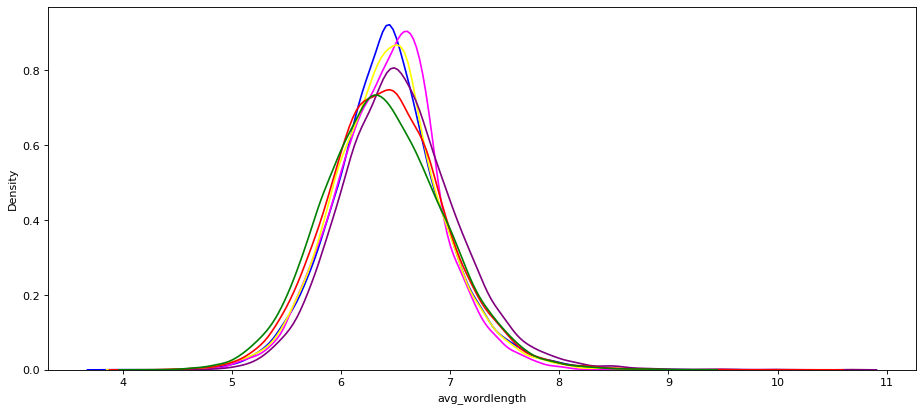

In [20]:
plt.rcParams['figure.figsize'] = [14,6]

sns.kdeplot(data_spec[data_spec['category']=="iade"]['avg_wordlength'], shade=False, color='blue')
sns.kdeplot(data_spec[data_spec['category']=="iptal"]['avg_wordlength'], shade=False, color='magenta')
sns.kdeplot(data_spec[data_spec['category']=="kredi-karti"]['avg_wordlength'], shade=False, color='yellow')
sns.kdeplot(data_spec[data_spec['category']=="musteri-hizmetleri"]['avg_wordlength'], shade=False, color='purple')
sns.kdeplot(data_spec[data_spec['category']=="hesap"]['avg_wordlength'], shade=False, color='red')
sns.kdeplot(data_spec[data_spec['category']=="kredi"]['avg_wordlength'], shade=False, color='green')

## Kelime kullanım frekansları ve Word Cloud

In [21]:
freqs = helper.word_frequency(data, 'text')

In [22]:
top20 = freqs[:20]

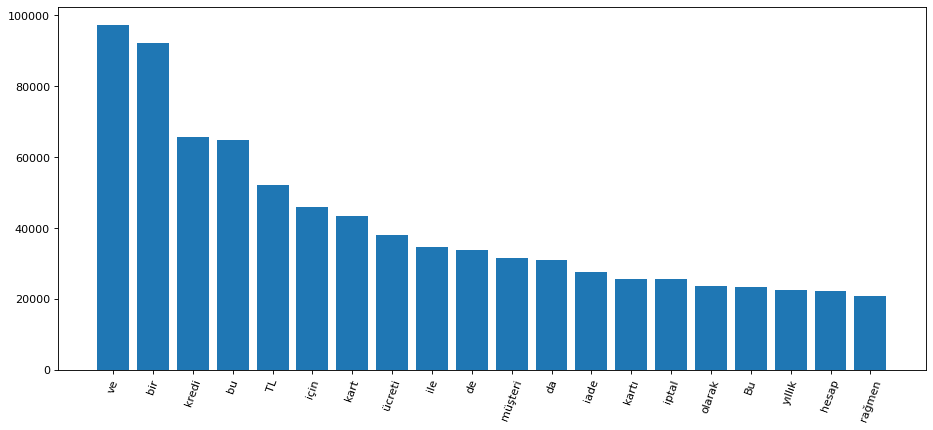

In [23]:
plt.rcParams['figure.figsize'] = [14,6]
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [24]:
least20 = freqs[-20:]
least20

kapattıklarım          1
Mesafede               1
bağırıyordum.          1
yansıtmayın.           1
faydalanamamış         1
dökülmüş               1
Bankkatt               1
kanıtlayacağımı        1
okullarında            1
3bine                  1
işlettirildi           1
201.000                1
yapabiliyoruz"         1
Stajım                 1
(yabancı               1
kamçı                  1
Halkbank-Halk          1
07.02.2020'da          1
Kocaeli/Çayırova'da    1
sıkışlığı              1
dtype: int64

#### En uzun karakter uzunluğuna sahip "iptal" kategorisi için ve en kısa karakter uzunluğuna sahip "kredi" kategorisi için Word Cloud

In [25]:
kredi_word_freq = helper.word_frequency(data[data['category']=="kredi"], 'text')
kredi_word_freq = ' '.join(kredi_word_freq.index)

'kredi' word cloud


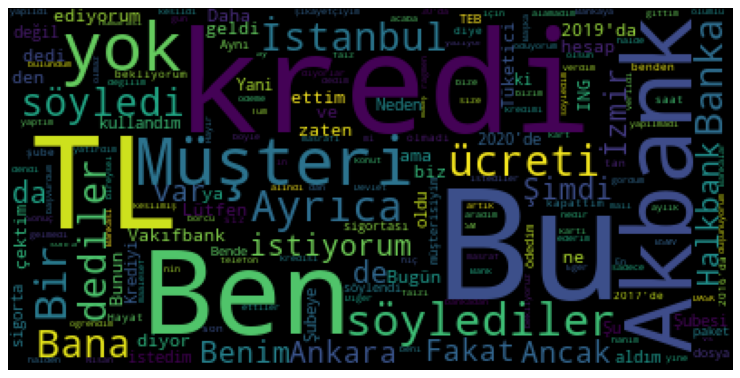

In [26]:
print("'kredi' word cloud")
word_cloud = WordCloud().generate(kredi_word_freq)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [27]:
iptal_word_freq = helper.word_frequency(data[data['category']=="iptal"], 'text')
iptal_word_freq = ' '.join(iptal_word_freq.index)

'iptal' word cloud


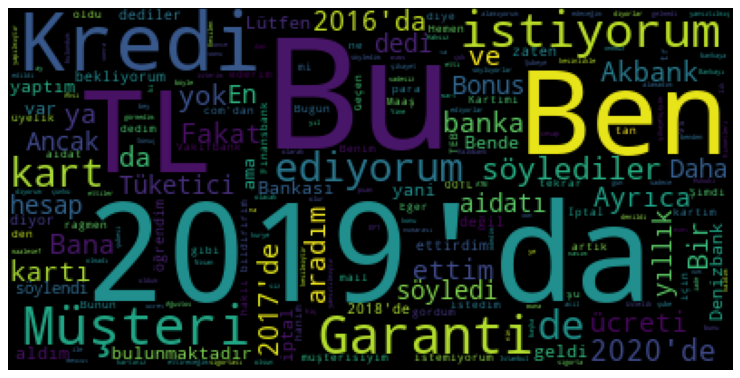

In [28]:
print("'iptal' word cloud")
word_cloud = WordCloud().generate(iptal_word_freq)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# ktrain ile preprocessing ve model kurma

Sci-kit learn kütüphanesindeki train_test_split fonksiyonu ile veriyi train, validation ve test setleri olmak üzere üçe böleceğim.

Split için 80/20 bölümünün uygun olduğuna karar verdim. Bundan önce yaptığım distilBERT model teslerinde 75/25 bölümünün düşük accuracy verdiğini, 90/10 bölümünün ise test verisi için düşük olduğunu gözlemledim.

In [29]:
data_train, data_test_val = train_test_split(data, test_size=0.20, random_state=42)

In [30]:
data_test, data_val = train_test_split(data_test_val, test_size=0.50, random_state=42)

In [31]:
data_test.shape, data_val.shape, data_train.shape

((9000, 5), (9000, 5), (72000, 5))

In [33]:
data_train.sample(5)

,text,category,char_counts,word_counts,avg_wordlength
4517,Akbank kredi kartım süresi dolduğu için gelmed...,kredi-karti,411,60,6.850000
301,ATM arızası ekranı güncelleme yapılmış. Bir mü...,kredi-karti,323,51,6.333333
55157,Düzenli olarak ödemesini yaptığım kredi kartım...,musteri-hizmetleri,262,39,6.717949
56809,08.02.2017 tarihinde Akbank kredi kartımdan şi...,musteri-hizmetleri,500,74,6.756757
44939,Yaklaşık 8.10 yıldır müşterinizim. Daha öncele...,hesap,541,80,6.762500


Ktrain sayesinde preprocessing işlemi çok basit bir şekilde aşağıdaki gibi yapılabiliyor.

In [35]:
(train, val, preproc) = text.texts_from_df(train_df=data_train, text_column='text', label_columns='category',
                   val_df = data_val,
                   maxlen = 280, # Sequence Length
                   preprocess_mode = 'distilbert') # distilBERT için özel preprocess

preprocessing train...
language: tr
train sequence lengths:
	mean : 67
	95percentile : 130
	99percentile : 195


Is Multi-Label? False
preprocessing test...
language: tr
test sequence lengths:
	mean : 66
	95percentile : 129
	99percentile : 196


Ktrain kütüphanesi içerisinde mevcut bulunan Sınıflandırma Modelleri

In [36]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


Modeli oluşturuyoruz

In [37]:
model = text.text_classifier(name = 'distilbert', train_data = train, preproc=preproc)

Is Multi-Label? False
maxlen is 280



done.


Modeli eğitmek için, kendi verimizi, oluşturduğumuz modeli ve batch size değerini verdiğimiz bir learner değişkeni oluşturuyoruz.

In [38]:
learner = ktrain.get_learner(model = model,
                             train_data = train,
                             val_data = val,
                             batch_size = 32)

lr_find() methodu, oluşturduğumuz modelin, kendi verimiz üzerinde kullancağı optimum başlangış learning rate değerini simüle etmeye yarıyor.

In [40]:
learner.lr_find(max_epochs=4)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
2250/2250 [==============================] - 1202s 534ms/step - loss: 1.3877 - accuracy: 0.4304
Epoch 2/4
2250/2250 [==============================] - 1204s 535ms/step - loss: 0.8004 - accuracy: 0.6894
Epoch 3/4
2250/2250 [==============================] - 1204s 535ms/step - loss: 1.8053 - accuracy: 0.1674
Epoch 4/4
2250/2250 [==============================] - 1203s 535ms/step - loss: 1.9990 - accuracy: 0.1691


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Aşağıdaki grafikte de görüldüğü üzere, 0.0001 değeri başlangıç learning rate değeri için optimal gözüküyor. Daha düşük bir değer olan 2e-5 değeriyle de denediğim bir model'de, modelin doğruluk oranında pek bir artış gözlemlemedim. Bu yüzden 0.0001 değerini seçeceğim.

Not: Learning rate simülasyon sırasında daha sağlıklı bir içgörü kazanmak için, epoch değerinin 4'ten daha yüksek olması daha sağlıklı olacaktır.

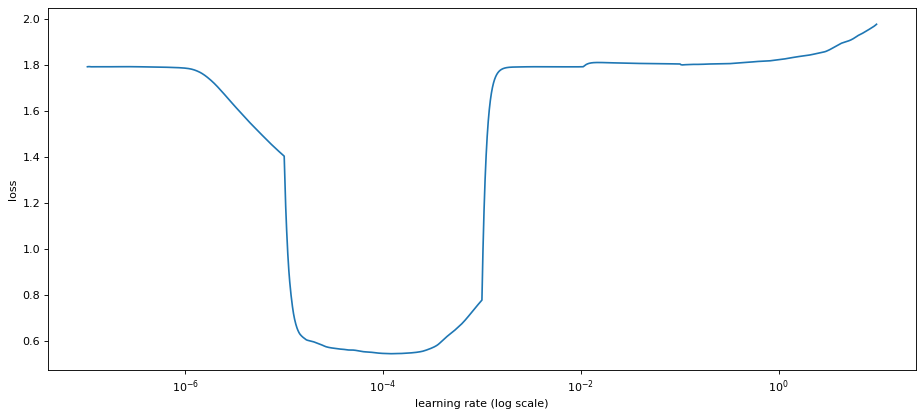

In [41]:
learner.lr_plot()

fit_onecycle() methodunu kullanarak modeli eğitmeye başlıyoruz.

Training boyunca her epoch başına accuracy ve loss değerleri, validation seti üzerinde yapılan teslerden çok farklı olmadığı için herhangi bir overfitting sorunu olmadığını düşünüyorum.

In [42]:
learner.fit_onecycle(lr = 0.0001, epochs=4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
2250/2250 [==============================] - 1259s 559ms/step - loss: 0.6348 - accuracy: 0.7580 - val_loss: 0.4410 - val_accuracy: 0.8297
Epoch 2/4
2250/2250 [==============================] - 1257s 559ms/step - loss: 0.4348 - accuracy: 0.8334 - val_loss: 0.4588 - val_accuracy: 0.8293
Epoch 3/4
2250/2250 [==============================] - 1258s 559ms/step - loss: 0.3902 - accuracy: 0.8494 - val_loss: 0.3754 - val_accuracy: 0.8564
Epoch 4/4
2250/2250 [==============================] - 1257s 559ms/step - loss: 0.3072 - accuracy: 0.8798 - val_loss: 0.3451 - val_accuracy: 0.8700


Eğitilmiş modeli bir predictor değişkenine tanımlıyoruz. Ktrain'in bu wrapper fonksiyonelliği sayesinde, üzerine tahmin yürütmek istediğimiz verileri tekrar preprocessing yapmadan kolayca kullanabiliyoruz.

In [43]:
predictor = ktrain.get_predictor(learner.model, preproc)

api'de kullanmak üzere Drive'a kaydediyorum.

In [44]:
predictor.save('/content/drive/My Drive/distilbert2')

Deneme amaçlı rastgele 3 tane string oluşturuyorum. Bunları yazarken kafamda yaptığım sınıflandırma sırasıyla, iptal/müşteri hizmetleri/kredi şeklinde.

In [45]:
data = ['kredi kartımı iptal etmek istiyorum',
        'ya arıyorum arıyorum açmıyorlar allah aşkına yeter artık ya bakanlığa şikayet edicem gerçekten',
        'para gerekiyor evlenmek üzereyim dedim işsiz olduğum için kredi veremeyiz dediler']

Model bu stringleri planladığım gibi tahmin etti. Demek ki model düzgün çalışıyor.

In [46]:
predictor.predict(data)

['iptal', 'musteri-hizmetleri', 'kredi']

In [48]:
predictor.get_classes()

['hesap', 'iade', 'iptal', 'kredi', 'kredi-karti', 'musteri-hizmetleri']

Aşağıda az önce oluşturduğum üç string için hangi kategoriyi ne kadar yüzdeyle tahmin ettiği görülüyor.

In [92]:
a = predictor.predict(data, return_proba=True)
np.set_printoptions(precision=9)
np.set_printoptions(suppress=True)
print("'hesap', '    iade', '    iptal', '   kredi', '   kredi-karti', 'musteri-hizmetleri'")
print(a)

'hesap', '    iade', '    iptal', '   kredi', '   kredi-karti', 'musteri-hizmetleri'
[[0.001052818 0.004794314 0.71839726  0.000843054 0.27359655  0.001315997]
 [0.112785906 0.004613759 0.017642934 0.012085514 0.02671575  0.8261562  ]
 [0.010701269 0.02810852  0.002967465 0.95656615  0.000189395 0.001467086]]


Training sonunda validation seti üzerinde 0.87 oranında accuracy elde edilmişti.

Test seti üzerinde ölçüm yaptığımızda çok yakın sonuçlar alıyoruz. Bu da modelde herhangi bir overfitting sorunu olmadığını gösteriyor.

Modelin tahmin yürütmekte en çok zorlandığı sınıf "kredi kartı" sınıfı olarak gözüküyor.

In [49]:
X_test = data_test["text"]
X_test = X_test.tolist()
pred = predictor.predict(X_test)

In [50]:
print(classification_report(data_test["category"], pred, target_names=predictor.get_classes()))

                    precision    recall  f1-score   support

             hesap       0.90      0.86      0.88      1549
              iade       0.87      0.84      0.86      1550
             iptal       0.90      0.93      0.91      1476
             kredi       0.90      0.89      0.90      1494
       kredi-karti       0.81      0.86      0.83      1464
musteri-hizmetleri       0.89      0.89      0.89      1467

          accuracy                           0.88      9000
         macro avg       0.88      0.88      0.88      9000
      weighted avg       0.88      0.88      0.88      9000



# API

Bu notebook'da oluşturulan model için kurulan api'yi, github repo'sunda distilbert_app adlı klasörün içinde bulabilirsiniz.
Api'yi FastAPI kullanarak oluşturdum.